<a href="https://colab.research.google.com/github/elliothebert/Portfolio_management/blob/main/portfolio_management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Management

The purpuse of this analysis is to optimize the allocation of a stock portfolio. We will use a Monte Carlo method, evaluate the sharpe ratio and compare the stocks individually with 2 benchmark.

In [3]:
import pandas as pd
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
!pip install quandl
import quandl

In [1]:
!pip install yfinance
import yfinance as yf

In [6]:
quandl.ApiConfig.api_key = "ywek9zq_ayRPip4z15N4"

In [20]:
#Google - Stock Price
start = pd.to_datetime('2012-01-01')
end = pd.to_datetime('2018-01-01')
data = quandl.get('WIKI/GOOGL', start_date = start, end_date=end)
data.head(10)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2012-01-03,652.94,668.15,652.370,665.41,7345600.0,0.0,1.0,327.480902,335.109451,327.195020,333.735209,7345600.0
2012-01-04,665.03,670.25,660.620,668.28,5722200.0,0.0,1.0,333.544620,336.162702,331.332793,335.174652,5722200.0
2012-01-05,662.13,663.97,656.230,659.01,6559200.0,0.0,1.0,332.090130,333.012979,329.130996,330.525300,6559200.0
2012-01-06,659.15,660.00,649.790,650.02,5380400.0,0.0,1.0,330.595517,331.021833,325.901025,326.016381,5380400.0
2012-01-09,646.50,647.00,621.230,622.46,11633500.0,0.0,1.0,324.250932,324.501706,311.576808,312.193712,11633500.0
2012-01-10,629.75,633.80,616.910,623.14,8782400.0,0.0,1.0,315.849999,317.881269,309.410119,312.534765,8782400.0
2012-01-11,623.50,629.39,621.124,625.96,4795200.0,0.0,1.0,312.715322,315.669441,311.523644,313.949131,4795200.0
2012-01-12,631.22,632.89,626.500,629.64,3746600.0,0.0,1.0,316.587275,317.424860,314.219967,315.794828,3746600.0
2012-01-13,626.26,626.95,621.060,624.99,4609900.0,0.0,1.0,314.099595,314.445664,311.491545,313.462629,4609900.0


In [21]:
df = data['Close']
df.head(10)

Date
2012-01-03    665.41
2012-01-04    668.28
2012-01-05    659.01
2012-01-06    650.02
2012-01-09    622.46
2012-01-10    623.14
2012-01-11    625.96
2012-01-12    629.64
2012-01-13    624.99
2012-01-17    628.58
Name: Close, dtype: float64

In [49]:
# United Health - Closing Stock Price
data2 = quandl.get('WIKI/UNH', start_date = start, end_date=end)
df2=data2['Close']
df2.head(10)

Date
2012-01-03    51.49
2012-01-04    52.24
2012-01-05    52.59
2012-01-06    52.78
2012-01-09    52.72
2012-01-10    52.62
2012-01-11    53.01
2012-01-12    52.87
2012-01-13    52.70
2012-01-17    53.57
Name: Close, dtype: float64

In [24]:
# Morgan Stanley - Closing Stock Price
data3 = quandl.get('WIKI/MS', start_date = start, end_date=end)
df3=data3['Close']
df3.head(10)

Date
2012-01-03    16.08
2012-01-04    15.94
2012-01-05    16.28
2012-01-06    15.90
2012-01-09    16.20
2012-01-10    16.89
2012-01-11    17.10
2012-01-12    17.17
2012-01-13    16.63
2012-01-17    16.25
Name: Close, dtype: float64

In [35]:
result = pd.concat([df, df2, df3], axis=1, join="inner")
result.columns =['GOOGL', 'UNH', 'MS']
result

,GOOGL,UNH,MS
Date,,,
2012-01-03,665.41,51.49,16.08
2012-01-04,668.28,52.24,15.94
2012-01-05,659.01,52.59,16.28
2012-01-06,650.02,52.78,15.90
2012-01-09,622.46,52.72,16.20
...,...,...,...
2017-12-22,1068.86,220.00,52.72
2017-12-26,1065.85,219.60,52.47
2017-12-27,1060.20,220.42,52.57


In [10]:
result.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1508 entries, 2012-01-03 to 2017-12-29
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GOOGL   1508 non-null   float64
 1   TSLA    1508 non-null   float64
 2   MS      1508 non-null   float64
dtypes: float64(3)
memory usage: 47.1 KB


Now that we have the data for the 3 companies in our portfolio, we will be able to start the analysis.
As in many financial models (Black-Scholes for example), it is better to calculate the log return over a long period instead of the average return.

In [37]:
log_return = np.log(1 + result.pct_change())

log_return

,GOOGL,UNH,MS
Date,,,
2012-01-03,NaN,NaN,NaN
2012-01-04,0.004304,0.014461,-0.008745
2012-01-05,-0.013969,0.006678,0.021106
2012-01-06,-0.013736,0.003606,-0.023618
2012-01-09,-0.043324,-0.001137,0.018692
...,...,...,...
2017-12-22,-0.001860,-0.007652,-0.003030
2017-12-26,-0.002820,-0.001820,-0.004753
2017-12-27,-0.005315,0.003727,0.001904


Regarding the allocation of equities in the portfolio, we will generate this randomly and then we will perform a Monte Carlo simulation in order to obtain the distribution that will allow us to have the best risk / return ratio (Sharpe Ratio) or the minimum volatility.

In [38]:
number_stocks = 3

random_weights = np.array(np.random.random(number_stocks))

sum_weights = np.sum(random_weights)

rebalance = random_weights / sum_weights 

rebalance

array([0.44960628, 0.02036457, 0.53002915])

In [39]:
daily_std = log_return.std()
daily_std

GOOGL    0.022427
UNH      0.012663
MS       0.018026
dtype: float64

In [40]:
annual_volatility = log_return.std()*252**.5
annual_volatility

GOOGL    0.356010
UNH      0.201023
MS       0.286154
dtype: float64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


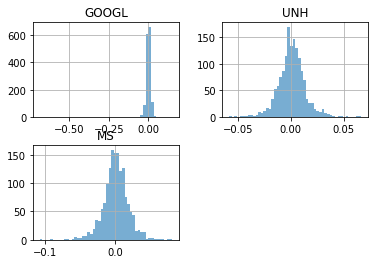

In [41]:
str_vol = str(round(annual_volatility, 4)*100)

fig, ax = plt.subplots()
log_return.hist(ax=ax, bins=50, alpha=0.6)
plt.show()

In [42]:
expected_return = np.sum(log_return.mean() * rebalance * 252)
expected_return

0.14431083740392758

In this project, we will consider that the risk free rate is equal to 1%

In [43]:
rf_rate = 0.01
sharpe_ratio = (expected_return - rf_rate)/annual_volatility
sharpe_ratio

GOOGL    0.377267
UNH      0.668136
MS       0.469365
dtype: float64

##Monte Carlo Simulation

In [44]:
number_stocks = 3
num_simulations = 1000

#preparing the numpy zeros array for the simulation
all_weights = np.zeros((num_simulations, number_stocks))

return_array = np.zeros(num_simulations)

volatility_array = np.zeros(num_simulations)

sharpe_array = np.zeros(num_simulations)

for x in range(num_simulations):
  weights = np.array(np.random.random(number_stocks))
  weights = weights / np.sum(weights)

  all_weights[x, :] = weights

  return_array[x] = np.sum(log_return.mean() * weights * 252)

  volatility_array[x] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))

  sharpe_array[x]=(return_array[x] - rf_rate)/volatility_array[x]



simulation = [return_array, volatility_array, sharpe_array, all_weights]

df = pd.DataFrame(data=simulation).T

df.columns = ["Return", "Volatility", "Sharpe Ratio", "Weights"]


print('')
print('=' * 80)
print('MONTE CARLO SIMULATIONS:')
print('=' * 80)
print(df.head())
print('=' * 80)





MONTE CARLO SIMULATIONS:
     Return  ...                                            Weights
0  0.136191  ...  [0.5277909354073879, 0.04979298112108261, 0.42...
1  0.162088  ...  [0.35057175285733005, 0.14801913834734462, 0.5...
2  0.158529  ...  [0.4908809905998571, 0.4432442517798383, 0.065...
3  0.199493  ...  [0.11256791337809414, 0.33775644685704775, 0.5...
4  0.177561  ...  [0.30625569296017147, 0.3706395527457373, 0.32...

[5 rows x 4 columns]


In [45]:
#Now we'll take the simulation with the best risk/reward

df['Sharpe Ratio'] = pd.to_numeric(df['Sharpe Ratio'])
max_sharpe_ratio = df.loc[df['Sharpe Ratio'].idxmax()]

#Now we'll take the simulation with the minimum of volatility (more conservative)
df['Volatility'] = pd.to_numeric(df['Volatility'])
min_volatility = df.loc[df['Volatility'].idxmin()]



print('') 
print('=' * 80) 
print('MAX SHARPE RATIO:') 
print('-' * 80) 
print(max_sharpe_ratio) 
print('-' * 80)


print('') 
print('=' * 80) 
print('MIN VOLATILITY:') 
print('-' * 80) 
print(min_volatility) 
print('-' * 80)


MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Return                                                   0.233568
Volatility                                               0.187961
Sharpe Ratio                                              1.18944
Weights         [0.00839030925294224, 0.8104841270449282, 0.18...
Name: 31, dtype: object
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
Return                                                   0.205539
Volatility                                               0.179068
Sharpe Ratio                                              1.09198
Weights         [0.17266648967007658, 0.6308436230148545, 0.19...
Name: 237, dtype: object
--------------------------------------------------------------------------------


Monte Carlo simulation is a great tool but it can problematic if we want to observe more simulations with a bigger dataset.

#Efficiency frontier line of the portfolio

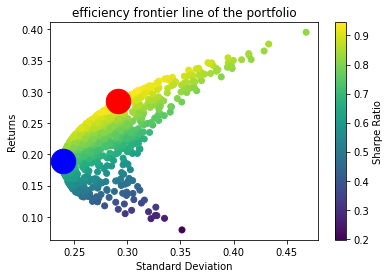

In [46]:
plt.scatter(
    x=df['Volatility'],
    y=df['Return'],
    c=df['Sharpe Ratio'])

plt.title("efficiency frontier line of the portfolio")
plt.colorbar(label="Sharpe Ratio")
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')


plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    color='r',
    s=600)


plt.scatter(
    min_volatility[1],
    min_volatility[0],
    color='b',
    s=600)


plt.show()

This graph illustrates very well the relationship between risk and return. the blue dot represents the portfolio with the minimum volatility and red the one with the best Sharpe Ratio.

#Benchmark

In order to assess their performance, portfolio managers compare their performance with indices such as the S&P500 in the United States or the TSX in Canada

In [46]:
data = yf.download("SPY ^GSPTSE", start="2012-01-01", end="2018-01-01")
data = data['Close']
data.head()

[*********************100%***********************]  2 of 2 completed


,SPY,^GSPTSE
Date,,
2012-01-03,127.500000,12208.400391
2012-01-04,127.699997,12226.500000
2012-01-05,128.039993,12237.400391
2012-01-06,127.709999,12188.599609
2012-01-09,128.020004,12196.700195


In [54]:
data_final = pd.concat([result, data], axis=1, join="inner")
data_final.columns =['GOOGL', 'UNH', 'MS', 'SP500', 'TSX']
data_final

,GOOGL,UNH,MS,SP500,TSX
Date,,,,,
2012-01-03,665.41,51.49,16.08,127.500000,12208.400391
2012-01-04,668.28,52.24,15.94,127.699997,12226.500000
2012-01-05,659.01,52.59,16.28,128.039993,12237.400391
2012-01-06,650.02,52.78,15.90,127.709999,12188.599609
2012-01-09,622.46,52.72,16.20,128.020004,12196.700195
...,...,...,...,...,...
2017-12-22,1068.86,220.00,52.72,267.510010,16165.299805
2017-12-26,1065.85,219.60,52.47,267.190002,NaN
2017-12-27,1060.20,220.42,52.57,267.320007,16203.099609


In [55]:
returns = data_final.apply(lambda x: x / x[0] * 100)
returns.head()

,GOOGL,UNH,MS,SP500,TSX
Date,,,,,
2012-01-03,100.000000,100.000000,100.000000,100.000000,100.000000
2012-01-04,100.431313,101.456594,99.129353,100.156860,100.148255
2012-01-05,99.038187,102.136337,101.243781,100.423524,100.237541
2012-01-06,97.687140,102.505341,98.880597,100.164705,99.837810
2012-01-09,93.545333,102.388813,100.746269,100.407846,99.904163


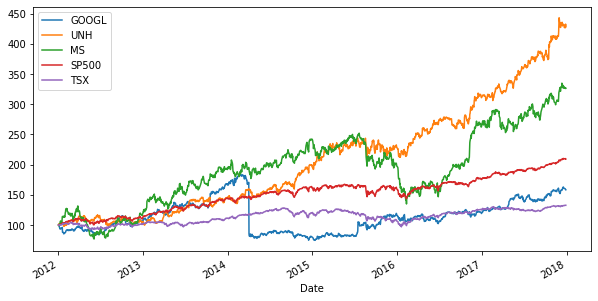

In [56]:
returns.plot(figsize=(10, 5))